In [1]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_actual_power, market_name_dict
# from private.db.tencnet.openmeteo.china_weather_forecast import ProvinceForecastData, forecast_slice
from private.db.tencnet.openmeteo.china_opemmeteo_forecast2 import ProvinceForecastData, forecast_slice

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla import VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer
import numpy
import pickle
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
from data_utils.serial_utils.series_trans_utils import MinMax

In [2]:
with open(f"E:\\code\\github\\private\\private\\db\\tencnet\\openmeteo\\data\\shanx_{TimeStamp(2024, 10, 1).get_date_string()}_5.pfd", "rb") as f:
    pfd: ProvinceForecastData = pickle.loads(f.read())

In [114]:
# ecmwf_morning_long = pfd.ecmwf_grid_morning_forecast[1][2]
ecmwf_morning_long = pfd.cma_forecast_matrix
ecmwf_morning_train_part1 = forecast_slice(ecmwf_morning_long, pfd, 1, 1)
ecmwf_morning_train_part2 = forecast_slice(ecmwf_morning_long, pfd, 2, 2)
ecmwf_morning_test = forecast_slice(ecmwf_morning_long, pfd, 3, 3)
ecmwf_morning_train = numpy.concatenate((ecmwf_morning_train_part1, ecmwf_morning_train_part2, ecmwf_morning_test))

print(ecmwf_morning_train.shape)
print(ecmwf_morning_test.shape)

(72, 4300)
(24, 4300)


In [79]:
actual_part1 = market_actual_power(market_name_dict["shanxi"], TimeStamp(2024, 10, 1).get_date_string()).aggregate(["hour", 1], numpy.sum, align=True, align_domain=["2024-10-1", "2024-10-2"])["power"]
actual_part2 = market_actual_power(market_name_dict["shanxi"], TimeStamp(2024, 10, 2).get_date_string()).aggregate(["hour", 1], numpy.sum, align=True, align_domain=["2024-10-2", "2024-10-3"])["power"]
actual_test = market_actual_power(market_name_dict["shanxi"], TimeStamp(2024, 10, 3).get_date_string()).aggregate(["hour", 1], numpy.sum, align=True, align_domain=["2024-10-3", "2024-10-4"])["power"]
actual_train = numpy.concatenate((actual_part1, actual_part2, actual_test))
print(actual_train.shape)
print(actual_test.shape)


(72,)
(24,)


In [110]:
input_size = ecmwf_morning_train.shape[1]
d_model = 512
dim_feedforward = d_model * 4
nhead = 8
output_size = 1
num_layers = 2
batch_size = 6
lr = 5e-6
model = VanillaTransformer(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

In [111]:
ecmwf_morning_train_tensor = torch.Tensor(numpy.apply_along_axis(MinMax.g, axis=0, arr=ecmwf_morning_train))
actual_train_tensor = torch.Tensor(numpy.apply_along_axis(MinMax.g, axis=0, arr=actual_train))
print(ecmwf_morning_train_tensor[0:5])

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.7551, 1.0000, 0.6149],
        [0.0141, 0.0000, 0.0000,  ..., 0.5182, 1.0000, 0.1930],
        [0.0282, 0.0000, 0.0000,  ..., 0.3968, 1.0000, 0.9292],
        [0.0423, 0.0000, 0.0000,  ..., 0.1581, 1.0000, 0.6124],
        [0.0563, 0.0000, 0.0000,  ..., 0.1003, 1.0000, 0.9497]])


In [112]:
trained_model = vanilla_transformer_trainer(model, ecmwf_morning_train_tensor, actual_train_tensor, batch_size, 100, lr=lr)

100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


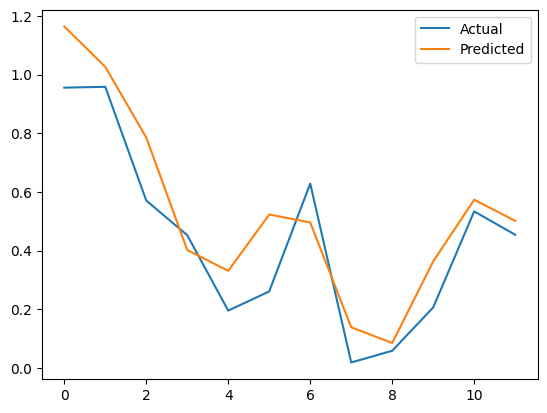

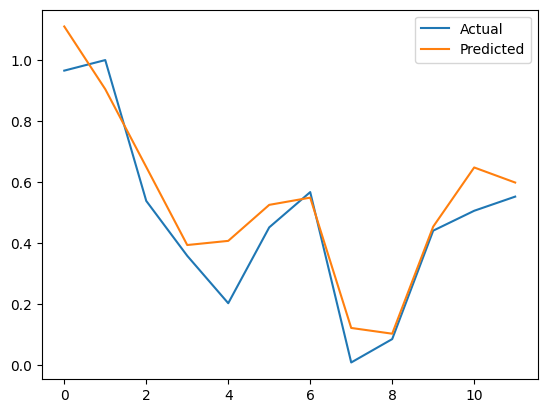

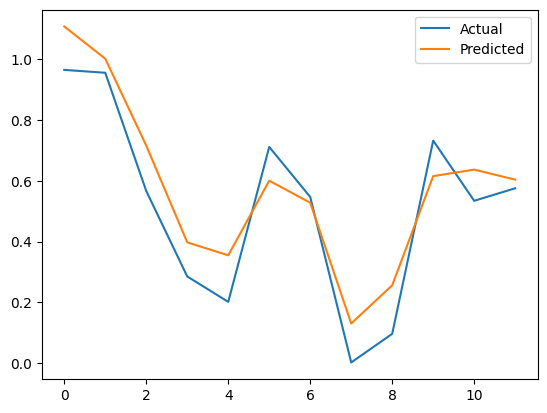

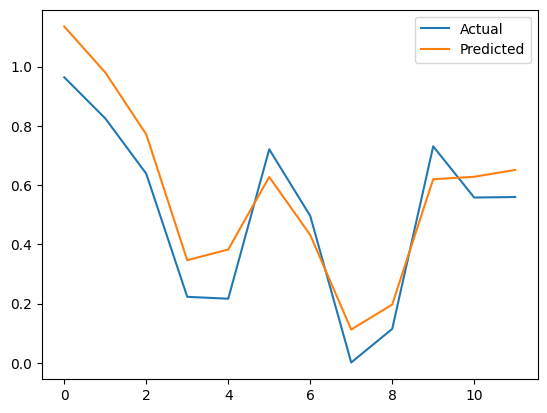

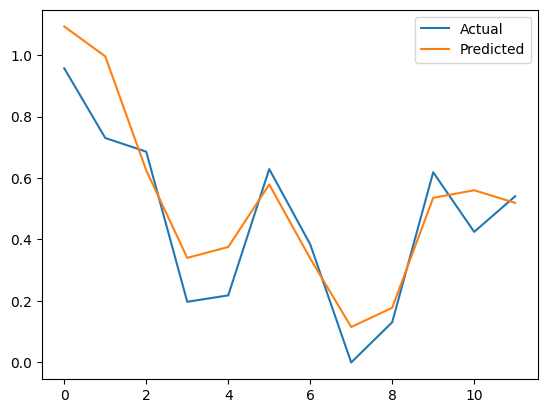

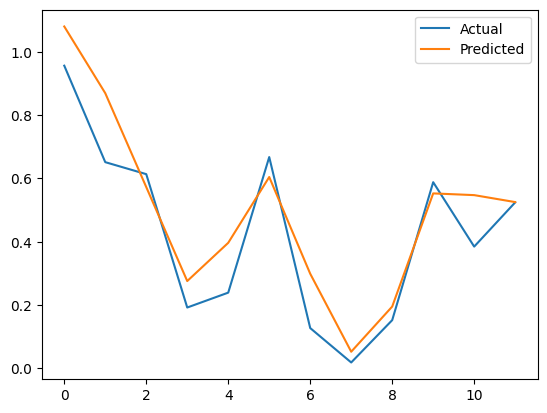

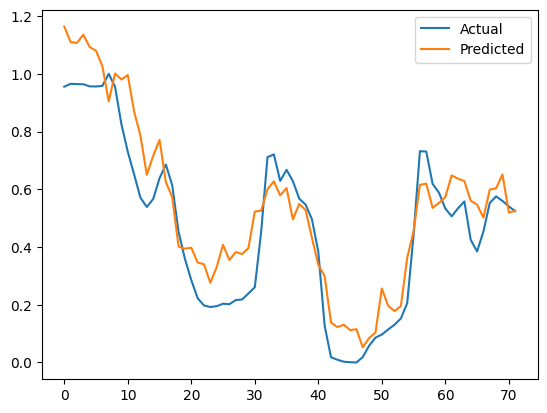

In [113]:
p_train = vanilla_transformer_tester(trained_model, ecmwf_morning_train_tensor, batch_size)
for _ in range(batch_size):
    plt.plot(actual_train_tensor.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p_train[:,_], label='Predicted')
    plt.legend()
    plt.show()
    
plt.plot(actual_train_tensor.reshape(-1), label='Actual')
plt.plot(p_train.reshape(-1), label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

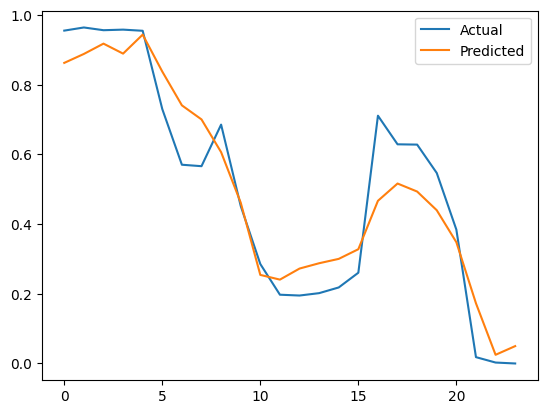

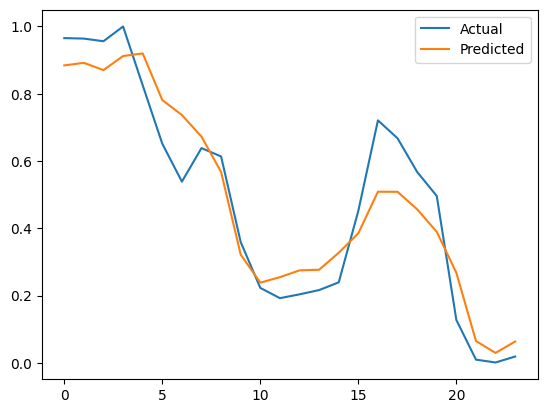

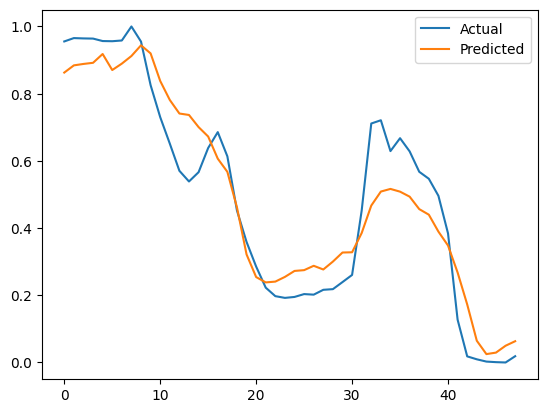

In [9]:
p_train = vanilla_transformer_tester(trained_model, ecmwf_morning_train_tensor, batch_size)
for _ in range(batch_size):
    plt.plot(actual_train_tensor.reshape(-1,batch_size,1)[:,_], label='Actual')
    plt.plot(p_train[:,_], label='Predicted')
    plt.legend()
    plt.show()
    
plt.plot(actual_train_tensor.reshape(-1), label='Actual')
plt.plot(p_train.reshape(-1), label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()